# Read a folder of folds

In [1]:
import csv
from collections import namedtuple

def read_score_log(file_name):
    '''
    Read generated verification data from a csv file.

    Return: tuple of recorded errors and accuracies
    '''
    Errors = []
    Accs = []
    VerificationRecord = namedtuple('VerificationRecord', 'opt_error, accuracy')
    
    with open(file_name) as csvfile:
        readCSV = map(VerificationRecord._make, csv.reader(csvfile, delimiter=','))
        for row in readCSV:
            Errors.append(float(row.opt_error))
            Accs.append(float(row.accuracy))
    return (Errors, Accs)

# Train centralised

In [2]:
import keras
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.model_selection import StratifiedKFold

input_size = 28*28
output_size = 10

# create model: à la 2NN
def get_2nn_model():
    model = Sequential()
    model.add(Dense(200, input_dim=input_size, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(output_size, activation='softmax'))

    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  #optimizer=keras.optimizers.SGD(lr=0.128, decay=1.15e-6),
                  optimizer=keras.optimizers.SGD(lr=7.03e-02, decay=3.77e-06),
                  metrics=['accuracy'])
    return model

def train_model(model, x_train, y_train, x_val, y_val, max_epochs=5, batch_size=10):
    
    es = EarlyStopping(monitor='val_acc', patience=8, min_delta=0.0001)
    
    history = model.fit(x_train, y_train, batch_size=batch_size, 
                       epochs=max_epochs, callbacks=[es], validation_data=(x_val, y_val))
    
    return history

/home/smith/miniconda3/envs/dml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import numpy
import struct

def read_mnist_data(fname_img, fname_lbl):
    '''
    Read MNIST data from a byte file.

    Return: tuple of inputs and labels (numpy)
    '''
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = numpy.fromfile(flbl, dtype=numpy.int8)
        if len(lbl) != num:
            print('Header mismatch. #labels != header number')

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = numpy.fromfile(fimg, dtype=numpy.uint8).reshape(num, rows, cols)

    return (img, lbl)

import os

def read_folds(folder_names, input_dir):
    '''
    Read data from every car for each fold
    '''
    folds = []

    for fold_name in folder_names:
        x_return = []
        y_return = []
        for car_i in range(1,101):
            # Read file
            input_directory = input_dir + fold_name
            label_file = "{}/car{}-labels.byte".format(input_directory, car_i)
            image_file = "{}/car{}-images.byte".format(input_directory, car_i)

            x, y = read_mnist_data(image_file, label_file)

            # accumulate/store chosen
            x_return.append(x)
            y_return.append(y)
        folds.append((numpy.concatenate(x_return), numpy.concatenate(y_return)))
        

    # return
    return folds

In [4]:
def train(folders, data_dir):
    input_size = 28*28
    output_size = 10
    accs_2NN = []
    for fold_id in range(5):
        data_folds = read_folds(folders, data_dir) # This is modified somewhere in the loop, not sure.
        x_test, y_test = data_folds[fold_id]
        x_test = x_test.reshape(x_test.shape[0], input_size)
        x_test = x_test.astype('float32')
        x_test /= 255
        y_test = keras.utils.to_categorical(y_test, output_size)
        x_train, y_train = zip(*[data_folds[x] for x in range(5) if x != fold_id])
        x_train = numpy.concatenate(x_train)
        y_train = numpy.concatenate(y_train)
        x_train = x_train.reshape(x_train.shape[0], input_size)
        x_train = x_train.astype('float32')
        x_train /= 255
        y_train = keras.utils.to_categorical(y_train, output_size)

        model = get_2nn_model()
        history = train_model(model, x_train, y_train, x_test, y_test, max_epochs=50, batch_size=10)
        
        accs = history.history['val_acc']
        losses = history.history['val_loss']
        log_path_name = f"../benchmark_results/centralised/score_log_CL_noniid_run2_cv{fold_id+1}.csv"
        if os.path.exists(log_path_name):
            os.remove(log_path_name)
        for loss, metric in zip(losses, accs):
            with open(log_path_name, 'a+') as log:
                log.write('{},{}\n'.format(loss, metric))
        accs_2NN.append(max(accs))
        print(f"Fold {fold_id+1} done. Next!")
    print("Done!")
    
if False:
    directory = '../src/data/mnist_noniid_cv/'
    folders = os.listdir(directory)
    train(folders, directory)
else:
    print("No training.")

No training.


# Read IID CL score logs

In [5]:
import glob

cl_logs = glob.glob("../benchmark_results/centralised/score_log_CL_iid*.csv")
cl_logs.sort()
cl_accs = [read_score_log(file)[1] for file in cl_logs]
cl_accs = np.array([max(x) for x in cl_accs])

print("Centralised Learning:", cl_accs)
cl_accs = cl_accs[:10]

Centralised Learning: [0.98271428 0.98364285 0.98378571 0.98364285 0.98514285 0.98442857
 0.98378571 0.98171428 0.9825     0.98557143]


# Read IID data

In [6]:
import glob
import numpy as np

fedavg_logs = glob.glob("../benchmark_results/fedavg/cross_validations_iid/*.csv")
fedavg_logs.sort()
fedavg_logs = fedavg_logs[:10]
fedavg_iid_accs = [read_score_log(file)[1] for file in fedavg_logs]
fedavg_iid_accs = np.array([max(x) for x in fedavg_iid_accs])

coop_logs = glob.glob("../benchmark_results/coop/cross_validations_iid/*.csv")
coop_logs.sort()
coop_logs = coop_logs[:10]
coop_accs = [read_score_log(file)[1] for file in coop_logs]
coop_accs = np.array([max(x[:1000]) for x in coop_accs])

fsvrg_logs = glob.glob("../benchmark_results/fsvrg/cross_validations_iid/*.csv")
fsvrg_logs.sort()
fsvrg_logs = fsvrg_logs[:10]
fsvrg_accs = [read_score_log(file)[1] for file in fsvrg_logs]
fsvrg_accs = np.array([max(x[:50]) for x in fsvrg_accs])

print("FedAvg\t", fedavg_iid_accs)
print("FSVRG\t", fsvrg_accs)
print("Coop\t", coop_accs)

FedAvg	 [0.98135714 0.98064286 0.98071429 0.98135714 0.98114286 0.97742857
 0.98135714 0.98042857 0.98214286 0.98192857]
FSVRG	 [0.97021429 0.96857143 0.9675     0.96907143 0.96885714 0.96628571
 0.97007143 0.96464286 0.96821429 0.96957143]
Coop	 [0.96914286 0.96857143 0.96757143 0.96778571 0.96685714 0.96521429
 0.96892857 0.96678571 0.96857143 0.96835714]


# Plot IID

In [7]:
import baycomp
%matplotlib inline

def bay_plot(res_A, res_B, save_file_name, runs=2, rope=0.01, names=("A", "B")):
    probs, plot = baycomp.two_on_single(res_A, res_B, runs=2, rope=0.01, plot=True, names=names)
    print(probs)
    plot.savefig(save_file_name, format='pdf', bbox_inches='tight')

(5.8043886718976855e-08, 0.9999997987901091, 1.4316600416286462e-07)


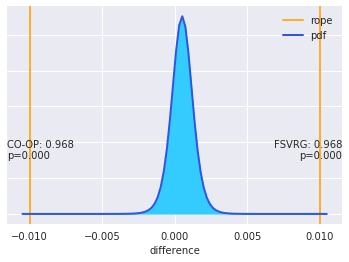

In [8]:
file_name = '../benchmark_results/posterior_iid_C_vs_FS.pdf'
bay_plot(coop_accs,
         fsvrg_accs,
         file_name,
         names=("CO-OP", "FSVRG"))

(9.802427957070346e-10, 0.00020874147838789714, 0.9997912575413693)


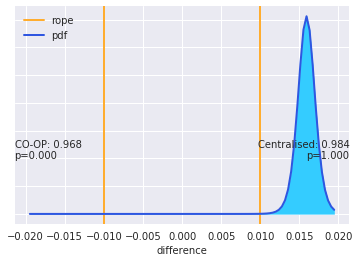

In [9]:
file_name = '../benchmark_results/posterior_iid_C_vs_CL.pdf'
bay_plot(coop_accs,
         cl_accs,
         file_name,
         names=("CO-OP", "Centralised"))

(5.310875090910757e-10, 0.00021314805352390387, 0.9997868514153886)


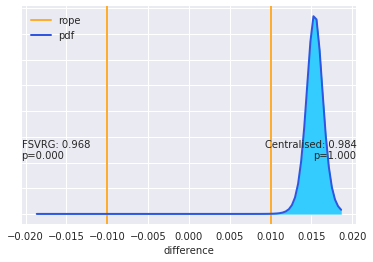

In [10]:
file_name = '../benchmark_results/posterior_iid_FS_vs_CL.pdf'
bay_plot(fsvrg_accs,
         cl_accs,
         file_name,
         names=("FSVRG", "Centralised"))

(0.9999546315563914, 4.536844236180393e-05, 1.2467804566540508e-12)


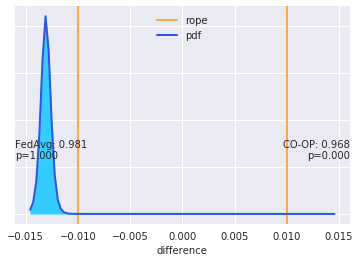

In [11]:
file_name = '../benchmark_results/posterior_iid_FA_vs_C.pdf'
bay_plot(fedavg_iid_accs,
         coop_accs,
         file_name,
         names=("FedAvg", "CO-OP"))

(0.9923274852154741, 0.007672514395357766, 3.8916814215639306e-10)


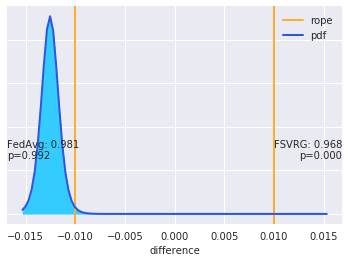

In [12]:
file_name = '../benchmark_results/posterior_iid_FA_vs_FS.pdf'
bay_plot(fedavg_iid_accs,
         fsvrg_accs,
         file_name,
         names=("FedAvg", "FSVRG"))

(4.548534662622213e-07, 0.9999474236543302, 5.212149220357176e-05)


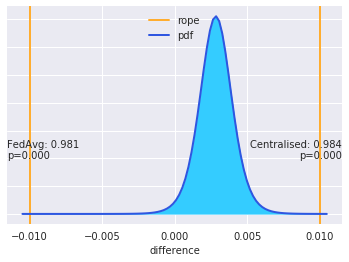

In [13]:
file_name = '../benchmark_results/posterior_iid_FA_vs_CL.pdf'
bay_plot(fedavg_iid_accs,
         cl_accs,
         file_name,
         names=("FedAvg", "Centralised"))

# Read non-IID result

In [14]:
import glob
import numpy as np

fedavg_logs = glob.glob("../benchmark_results/fedavg/cross_validations/*.csv")
fedavg_logs.sort()
fedavg_logs = fedavg_logs[:10]
fedavg_noniid_accs = [read_score_log(file)[1] for file in fedavg_logs]
fedavg_noniid_accs = np.array([max(x) for x in fedavg_noniid_accs])

coop_logs = glob.glob("../benchmark_results/coop/cross_validations/*.csv")
coop_logs.sort()
coop_logs = coop_logs[:10]
coop_accs = [read_score_log(file)[1] for file in coop_logs]
coop_accs_few = np.array([max(x[:1000]) for x in coop_accs])
coop_accs_plus = np.array([max(x) for x in coop_accs])

fsvrg_logs = glob.glob("../benchmark_results/fsvrg/cross_validations/*.csv")
fsvrg_logs.sort()
fsvrg_logs = fsvrg_logs[:10]
fsvrg_accs = [read_score_log(file)[1] for file in fsvrg_logs]
fsvrg_accs_few = np.array([max(x[:50]) for x in fsvrg_accs])
fsvrg_accs_plus = np.array([max(x[:500]) for x in fsvrg_accs])

print("FedAvg\t", fedavg_noniid_accs)
print("FSVRG\t", fsvrg_accs_few)
print("FSVRG+\t", fsvrg_accs_plus)
print("Coop\t", coop_accs_few)
print("Coop+\t", coop_accs_plus)

FedAvg	 [0.96314286 0.96842857 0.96935714 0.9715     0.96521429 0.97121429
 0.97057143 0.967      0.967      0.96207143]
FSVRG	 [0.8705     0.84657143 0.82307143 0.87778571 0.82278571 0.81814286
 0.85228571 0.83342857 0.81892857 0.83364286]
FSVRG+	 [0.97471429 0.97221429 0.97507143 0.98771429 0.96785714 0.97528571
 0.976      0.97564286 0.97085714 0.97464286]
Coop	 [0.90935714 0.90821429 0.9055     0.90757143 0.90428571 0.90857143
 0.90914286 0.91321429 0.90585714 0.91071429]
Coop+	 [0.95778571 0.95685714 0.95542857 0.95714286 0.952      0.956
 0.95635714 0.95442857 0.95271429 0.955     ]


# Plot non-IID FL

## FedAvg vs CO-OP

(0.9999999895995596, 9.888049268269583e-09, 5.123911295257244e-10)


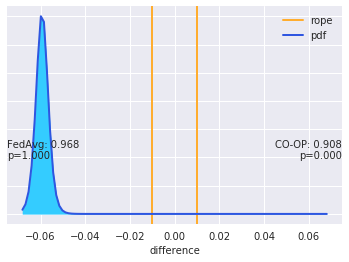

In [15]:
file_name = '../benchmark_results/posterior_FA_vs_C.pdf'
bay_plot(fedavg_noniid_accs,
         coop_accs_few,
         file_name,
         names=("FedAvg", "CO-OP"))

## FedAvg vs FSVRG

(0.999996624448679, 2.4600942034602724e-06, 9.154571175562509e-07)


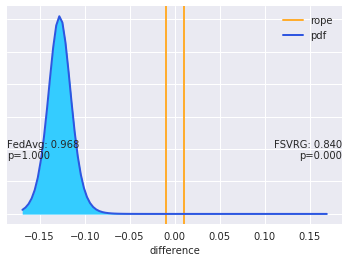

In [16]:
file_name = '../benchmark_results/posterior_FA_vs_FS.pdf'
bay_plot(fedavg_noniid_accs,
         fsvrg_accs_few,
         file_name,
         names=("FedAvg", "FSVRG"))

## CO-OP vs FSVRG

(0.9994597962296371, 0.00047301804039323603, 6.718572996966543e-05)


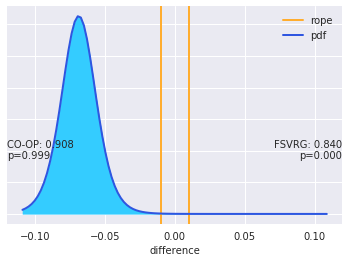

In [17]:
file_name = '../benchmark_results/posterior_C_vs_FS.pdf'
bay_plot(coop_accs_few,
         fsvrg_accs_few,
         file_name,
         names=("CO-OP", "FSVRG"))

# CL vs FL non-IID

In [18]:
import glob

cl_logs = glob.glob("../benchmark_results/centralised/score_log_CL_noniid*.csv")
cl_logs.sort()
cl_accs = [read_score_log(file)[1] for file in cl_logs]
cl_accs = np.array([max(x) for x in cl_accs])

print("Centralised Learning:", cl_accs)
cl_accs = cl_accs[:10]

Centralised Learning: [0.98392857 0.98314285 0.983      0.98442857 0.98557143 0.98221428
 0.98285714 0.98542857 0.98257143 0.98414285]


(6.803441960946128e-07, 0.013271822398442934, 0.986727497257361)


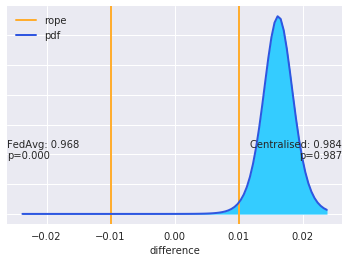

In [19]:
file_name = '../benchmark_results/posterior_FA_vs_CL.pdf'
bay_plot(fedavg_noniid_accs,
         cl_accs,
         file_name,
         names=("FedAvg", "Centralised"))

(6.113527305231983e-13, 6.059930335311492e-12, 0.9999999999933287)


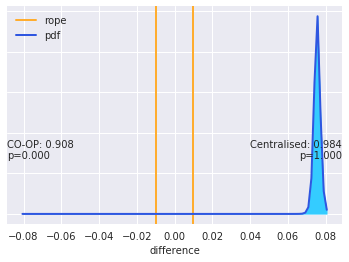

In [20]:
file_name = '../benchmark_results/posterior_C_vs_CL.pdf'
bay_plot(coop_accs_few,
         cl_accs,
         file_name,
         names=("CO-OP", "Centralised"))

(3.2379742684559565e-07, 7.280642997375963e-07, 0.9999989481382734)


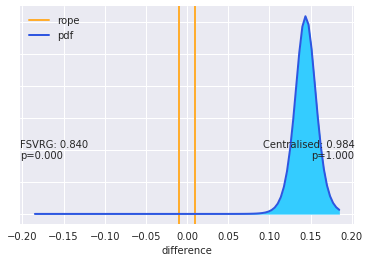

In [21]:
file_name = '../benchmark_results/posterior_FS_vs_CL.pdf'
bay_plot(fsvrg_accs_few,
         cl_accs,
         file_name,
         names=("FSVRG", "Centralised"))

# Longer runs

(0.8512401908734699, 0.1487591466910846, 6.624354454976e-07)


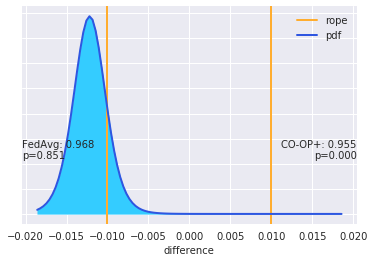

In [22]:
file_name = '../benchmark_results/posterior_FA_vs_Cp.pdf'
bay_plot(fedavg_noniid_accs,
         coop_accs_plus,
         file_name,
         names=("FedAvg", "CO-OP+"))

(6.049939767182955e-05, 0.8139542562688419, 0.1859852443334863)


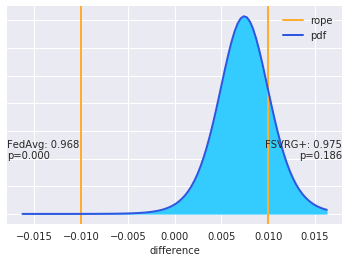

In [23]:
file_name = '../benchmark_results/posterior_FA_vs_FSp.pdf'
bay_plot(fedavg_noniid_accs,
         fsvrg_accs_plus,
         file_name,
         names=("FedAvg", "FSVRG+"))

(4.70709100405945e-07, 0.0020803999413838703, 0.9979191293495158)


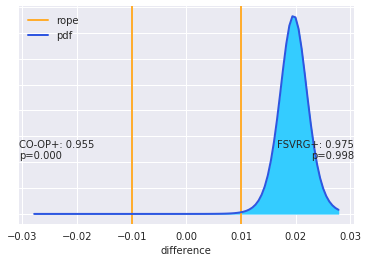

In [24]:
file_name = '../benchmark_results/posterior_Cp_vs_FSp.pdf'
bay_plot(coop_accs_plus,
         fsvrg_accs_plus,
         file_name,
         names=("CO-OP+", "FSVRG+"))

(4.4686745146015394e-10, 2.836898362890139e-07, 0.9999997158632963)


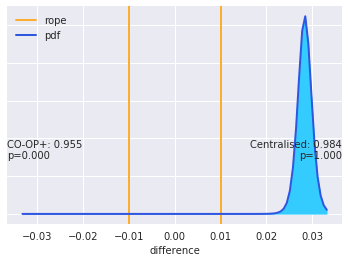

In [25]:
file_name = '../benchmark_results/posterior_Cp_vs_CL.pdf'
bay_plot(coop_accs_plus,
         cl_accs,
         file_name,
         names=("CO-OP+", "Centralised"))

(9.776604929048776e-05, 0.653945271001594, 0.3459569629491155)


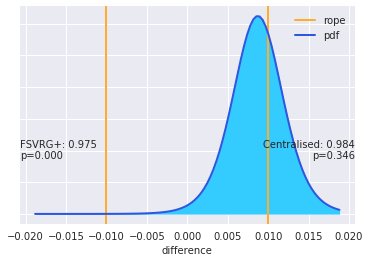

In [26]:
file_name = '../benchmark_results/posterior_FSp_vs_CL.pdf'
bay_plot(fsvrg_accs_plus,
         cl_accs,
         file_name,
         names=("FSVRG+", "Centralised"))